## Motivation

- Open-loop data ⇒ PEM unbiased.

- Closed-loop ⇒ input and disturbance become correlated → biased model.

- Many industrial systems (chemical plants, motors, etc.) can only be tested in closed loop.

- Hence: Instrumental Variable (IV) methods allow identification without opening the loop.

# Indroduction

Identification problem is usualy problem of finding coeficients of difference or differential equations that relates mesured input $u(t)$ to mesured output $y(t)$ for discrete or continious systems respectivly.

Those equations can be represendted by a model such as:
* transfer function
* polynomial model
* state space model

As an example we take ARX model (AutoRegressive model with eXogenous inputs):
$$
  A(q)y(t) = B(q)u(t) + e(t)
$$

where $e(t)$ are unmesured disturbances typicaly discribed as Gaussian white noise of a zero mean and constant variance.

For simplification we are using:
$$
  A(q) = 1 - aq^{-1} \quad B(q) = bq^{-1}
$$
So ARX model is:
$$
  y(t) = ay(t-1) + bu(t-1) + e(t)
$$


# Instrumental Variables

* We dentoe instrumental varibale as $x(t)$
* Then we want to chose $x(t)$ to corelate out $e(t)$ from the equations. This is best seen when using the correlation based approach to solving stochastic difference equations.

$$
  E\{x(t)y(t)\} = aE\{x(t)y(t-1)\} + bE\{x(t)u(t-1)\} + E\{x(t)e(t)\}
$$

$$
  E\{x(t)y(t)\} = R_{xy}(0)
$$

$$
  R_{xy}(0) = a R_{xy}(1) + b R_{xu}(1) + R_{xe}(0)
$$

We usualy pick instrumentall variable such that it has strong correlation with the output $y(t)$ but is uncorrelated with the disturbance $e(t)$:

$$
  x(t) = y(t-1)
$$

$$
  R_yy(1) = aR_{yy}(0) + bR_{yu}(0) + R_{ye}(1)
$$

Since $e(t)$ is uncorrelated with $y(t-1)$ we have $R_{ye}(1) \approx 0$.

This way we managed to correlate out the effect of $e(t)$.



# Identification of ARX models

Given samples of IO signals over a time range, we need to solve for the coefficients of the delay operator polys $A(q)B(q)$. We can minimize sum of squared arror over a time:
$$
  V = \frac{1}{N}\sum_t e^2(t)
$$
Define:
$$
\Phi =
\begin{bmatrix}
  y_1 & u_1\\
  y_2 & u_2\\
  \vdots & \vdots\\
  y_{N-1} & u_{N-1}
\end{bmatrix} , \quad
Y =
\begin{bmatrix}
  y_2\\
  y_3\\
  \vdots\\
  y_{N}
\end{bmatrix}
$$

$$
\Phi \theta = Y, \quad \theta =
\begin{bmatrix}
  a\\
  b
\end{bmatrix}
$$

### Stohastic Difference Equation Based Approach to Estimation

$$
\theta = \left[ \frac{1}{N} \sum_{t=1}^N \phi(t)\phi^T(t) \right] \left[ \frac{1}{N} \sum_{t=1}^N \phi(t)y(t) \right]
$$

$$
\theta = \left[ \frac{1}{N} \sum_{t=1}^N x(t)\phi^T(t) \right] \left[ \frac{1}{N} \sum_{t=1}^N x(t)y(t) \right]
$$


You do not need to generate the regressor data manually. You can simply provide a filtered version of the output signals to be used for generating the instrumental variables.

# Output-Error form

The ARX estimation technique provides correct estimates of the model parameters if the disturbances are indeed equation errors. They match the manner in which $e(t)$ affects output $y(t)$.

In many situations this is not a case. This is if unmesured disturbances are owing to sensor measurement noise. In this case system taks the form:

$$
y(t) = \frac{B(q)}{A(q)}u(t) + e(t)
$$

In this case ARX model for estimation leads to BIASED estimates of the model parameters.

The OE estimatior  estimates the coefficients of the numerator and the denominator polynomials by minimizing the sum of squares of the errors $e(t)$
However, the minimization objective V is non-convex in the model parameters so minimization uses iterative numerical minimization techniques. Best results are typically not guaranteed since the minimization algorithms can get stuck at a local minima of V


## Simple Example

True: a1=0.7, b0=0.5
OLS (biased): a1=0.714, b0=0.523
IV (consistent): a1=0.673, b0=0.509


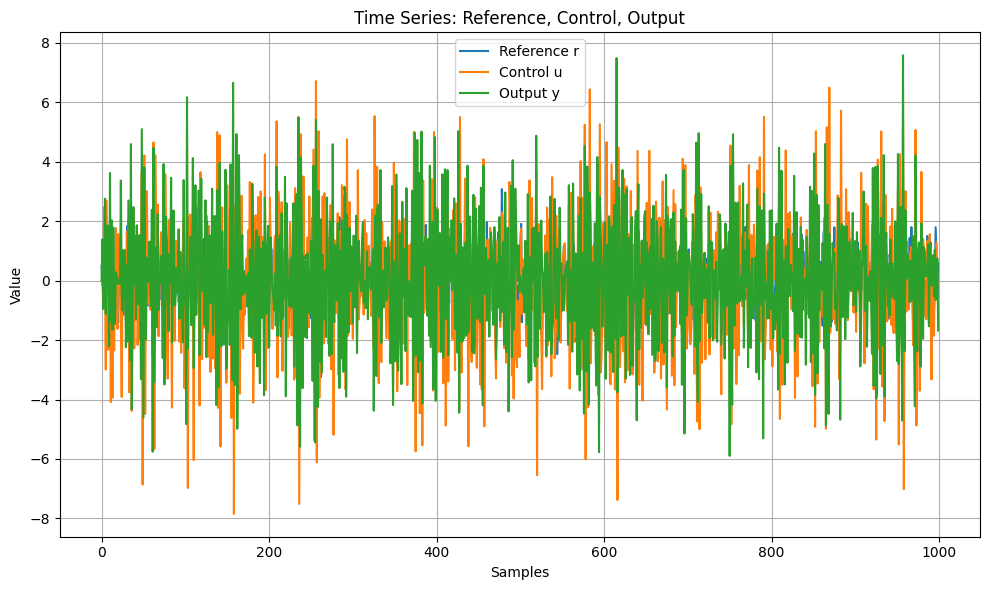

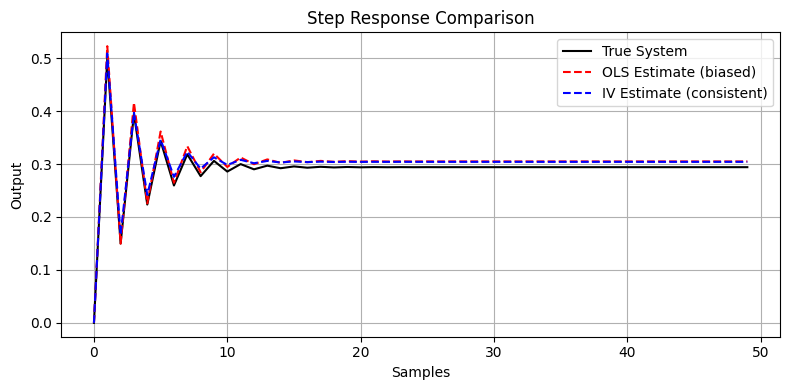

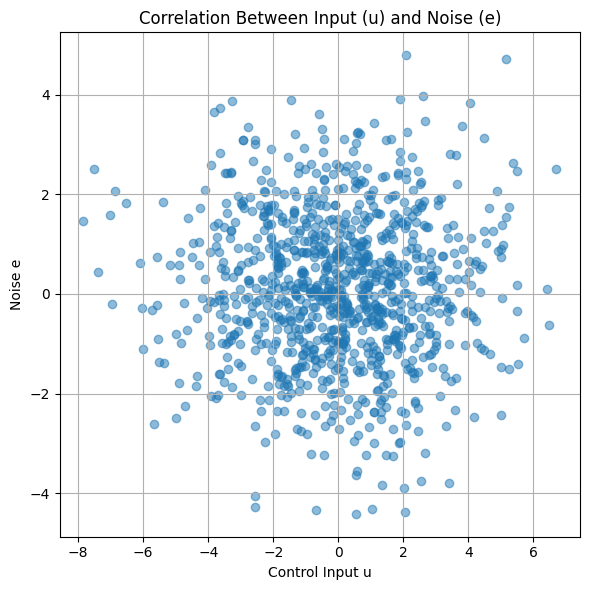

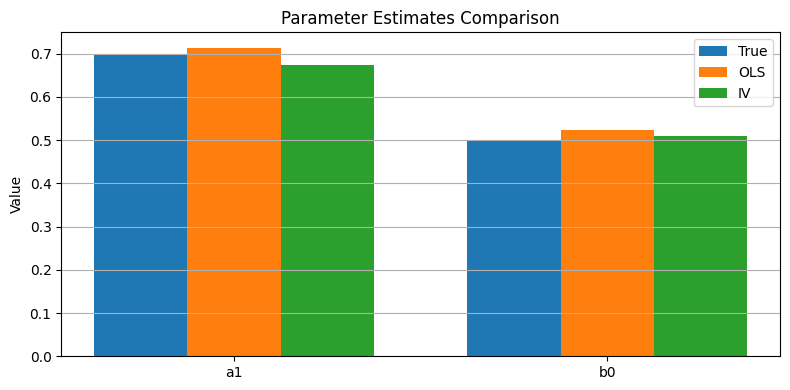

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Setup ---
np.random.seed(42)
a1 = 0.7       # True system parameter
b0 = 0.5       # True system parameter
K = 1.0        # Controller gain
N = 1000       # Simulation length

# --- 2. Generate signals ---
r = np.random.randn(N)           # Reference signal
e = 1.5 * np.random.randn(N)     # Disturbance
y = np.zeros(N)
u = np.zeros(N)

# --- 3. Closed-loop simulation ---
for t in range(1, N):
    u[t] = -K * y[t-1] + r[t]                 # Feedback control
    y[t] = -a1 * y[t-1] + b0 * u[t-1] + e[t]  # Plant dynamics

# --- 4. Regression data ---
phi = np.column_stack([-y[:-1], u[:-1]])  # regressors
Y = y[1:]

# --- 5. OLS estimation ---
theta_ls = np.linalg.pinv(phi.T @ phi) @ phi.T @ Y
a1_hat_ls, b0_hat_ls = theta_ls

# --- 6. IV estimation using lagged reference ---
Z = np.column_stack([-r[:-1], np.roll(r, 1)[:-1]])
Z[0, :] = 0
theta_iv = np.linalg.pinv(Z.T @ phi) @ (Z.T @ Y)
a1_hat_iv, b0_hat_iv = theta_iv

print(f"True: a1={a1}, b0={b0}")
print(f"OLS (biased): a1={a1_hat_ls:.3f}, b0={b0_hat_ls:.3f}")
print(f"IV (consistent): a1={a1_hat_iv:.3f}, b0={b0_hat_iv:.3f}")

# --- 7. Step response function ---
def step_response(a1, b0, N=50):
    y = np.zeros(N)
    u = np.ones(N)
    for t in range(1, N):
        y[t] = -a1 * y[t-1] + b0 * u[t-1]
    return y

y_true = step_response(a1, b0)
y_ls = step_response(a1_hat_ls, b0_hat_ls)
y_iv = step_response(a1_hat_iv, b0_hat_iv)

# --- Plot 1: Time series ---
plt.figure(figsize=(10, 6))
plt.plot(r, label='Reference r')
plt.plot(u, label='Control u')
plt.plot(y, label='Output y')
plt.title('Time Series: Reference, Control, Output')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot 2: Step response comparison ---
plt.figure(figsize=(8, 4))
plt.plot(y_true, 'k', label='True System')
plt.plot(y_ls, '--r', label='OLS Estimate (biased)')
plt.plot(y_iv, '--b', label='IV Estimate (consistent)')
plt.title('Step Response Comparison')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot 3: Correlation between input and noise ---
plt.figure(figsize=(6, 6))
plt.scatter(u, e, alpha=0.5)
plt.title('Correlation Between Input (u) and Noise (e)')
plt.xlabel('Control Input u')
plt.ylabel('Noise e')
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot 4: Parameter estimates comparison ---
params = ['a1', 'b0']
true_vals = [a1, b0]
ols_vals = [a1_hat_ls, b0_hat_ls]
iv_vals = [a1_hat_iv, b0_hat_iv]

x = np.arange(len(params))
width = 0.25
plt.figure(figsize=(8, 4))
plt.bar(x - width, true_vals, width, label='True')
plt.bar(x, ols_vals, width, label='OLS')
plt.bar(x + width, iv_vals, width, label='IV')
plt.xticks(x, params)
plt.ylabel('Value')
plt.title('Parameter Estimates Comparison')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

OLS estimate (biased): a1=0.493, a2=-1.143, b0=0.416, b1=-0.105
IV estimate (consistent): a1=0.455, a2=-1.363, b0=0.491, b1=-0.165


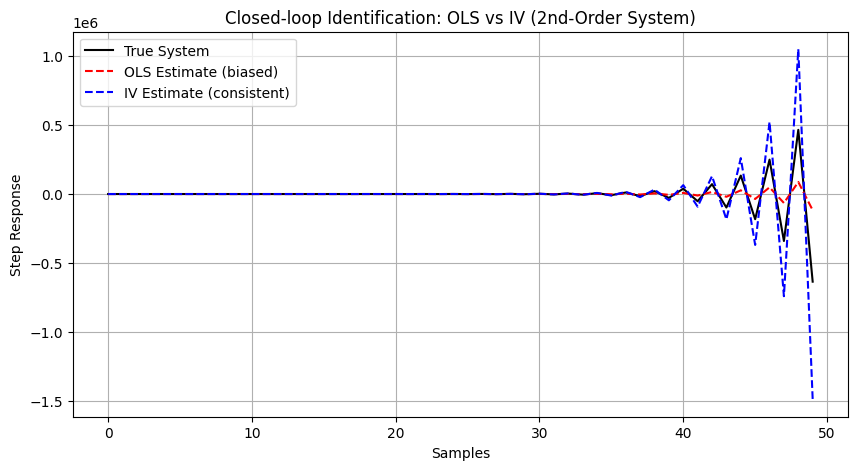

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# --- 1. True second-order system parameters ---
a1, a2 = 1.0, -0.5
b0, b1 = 0.5, 0.1

# --- 2. PID controller gains ---
Kp, Ki, Kd = 1.0, 0.2, 0.1

# --- 3. Simulation setup ---
N = 1000

# Pseudo-random reference signal (PRBS)
r = np.random.choice([-1, 1], size=N)

# Colored noise: AR(1) process
e = np.zeros(N)
for t in range(1, N):
    e[t] = 0.8*e[t-1] + 0.5*np.random.randn()

y = np.zeros(N)
u = np.zeros(N)
integral = 0

# --- 4. Closed-loop simulation with PID ---
for t in range(2, N):
    error = r[t] - y[t-1]
    integral += error
    derivative = error - (r[t-1] - y[t-2])
    u[t] = Kp*error + Ki*integral + Kd*derivative
    y[t] = -a1*y[t-1] - a2*y[t-2] + b0*u[t-1] + b1*u[t-2] + e[t]

# --- 5. Prepare regression data ---
phi = np.column_stack([-y[1:-1], -y[:-2], u[1:-1], u[:-2]])
Y = y[2:]

# --- 6. OLS estimate (biased under feedback) ---
theta_ls = np.linalg.pinv(phi.T @ phi) @ phi.T @ Y
a1_hat_ls, a2_hat_ls, b0_hat_ls, b1_hat_ls = theta_ls
print(f"OLS estimate (biased): a1={a1_hat_ls:.3f}, a2={a2_hat_ls:.3f}, b0={b0_hat_ls:.3f}, b1={b1_hat_ls:.3f}")

# --- 7. IV estimation using lagged reference as instruments ---
Z = np.column_stack([
    -r[1:-1],    # lag 1 of reference
    -r[:-2],     # lag 2 of reference
    u[:-2],      # lag 1 of input
    u[1:-1]      # lag 2 of input aligned with phi
])
Z[:2, :] = 0  # fix first invalid samples

theta_iv = np.linalg.pinv(Z.T @ phi) @ (Z.T @ Y)
a1_hat_iv, a2_hat_iv, b0_hat_iv, b1_hat_iv = theta_iv
print(f"IV estimate (consistent): a1={a1_hat_iv:.3f}, a2={a2_hat_iv:.3f}, b0={b0_hat_iv:.3f}, b1={b1_hat_iv:.3f}")

# --- 8. Step response function ---
def step_response(a1, a2, b0, b1, N=50):
    y = np.zeros(N)
    u = np.ones(N)
    for t in range(2, N):
        y[t] = -a1*y[t-1] - a2*y[t-2] + b0*u[t-1] + b1*u[t-2]
    return y

y_true = step_response(a1, a2, b0, b1)
y_ls = step_response(a1_hat_ls, a2_hat_ls, b0_hat_ls, b1_hat_ls)
y_iv = step_response(a1_hat_iv, a2_hat_iv, b0_hat_iv, b1_hat_iv)

# --- 9. Plot comparison ---
plt.figure(figsize=(10,5))
plt.plot(y_true, 'k', label='True System')
plt.plot(y_ls, '--r', label='OLS Estimate (biased)')
plt.plot(y_iv, '--b', label='IV Estimate (consistent)')
plt.title("Closed-loop Identification: OLS vs IV (2nd-Order System)")
plt.xlabel("Samples")
plt.ylabel("Step Response")
plt.legend()
plt.grid(True)
plt.show()


## Advanced Example

In [ ]:
# %%bash
#Optional: install required packages. Uncomment and run if packages are not present.
#Note: run this cell in your local environment (internet required).
!pip install sysidentpy scipy numpy pandas matplotlib

In [ ]:
# Imports and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, optimize
from numpy.linalg import lstsq, inv
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Simulation parameters
np.random.seed(42)
N = 1000
ts = 0.1  # sample time (s)

# True discrete transfer function (numerator/denominator for z^-1)
# We'll set B = [0, b1, b2] to indicate delay nk=1 conveniently when using lfilter.
b1_true, b2_true = 0.9, 1.1
B = [0.0, b1_true, b2_true]   # B(z) = 0 + b1 z^-1 + b2 z^-2
A = [1.0, -1.5, 0.7]          # A(z) = 1 - 1.5 z^-1 + 0.7 z^-2

# Input: white noise (optionally filtered to be smoother)
u = np.random.normal(scale=1.0, size=N)

# Simulate noise-free output y_true via difference equation using lfilter
# Note: lfilter assumes polynomials in ascending powers of z^-1: y * A = u * B -> use signal.lfilter(B, A, u)
y_true = signal.lfilter(B, A, u)

# Add process/noise to create y1 measurement and auxiliary sensor y2
# Measurement noise for y1 is correlated with input to simulate problematic noise (bias for LS)
noise_corr = 0.4 * np.roll(u, 1)  # correlation term using u(t-1)
noise_corr[0] = 0.0
noise_white = np.random.normal(scale=0.5, size=N)
e1 = noise_corr + noise_white  # measurement noise on primary sensor

# Auxiliary sensor noise is independent
e2 = np.random.normal(scale=0.5, size=N)

y1 = y_true + e1
y2 = y_true + e2

# Create a pandas DataFrame similar to MATLAB timetable / IOData
time = np.arange(N) * ts
IOData = pd.DataFrame({'time': time, 'u1': u, 'y1': y1, 'y2': y2})
IOData = IOData.set_index('time')

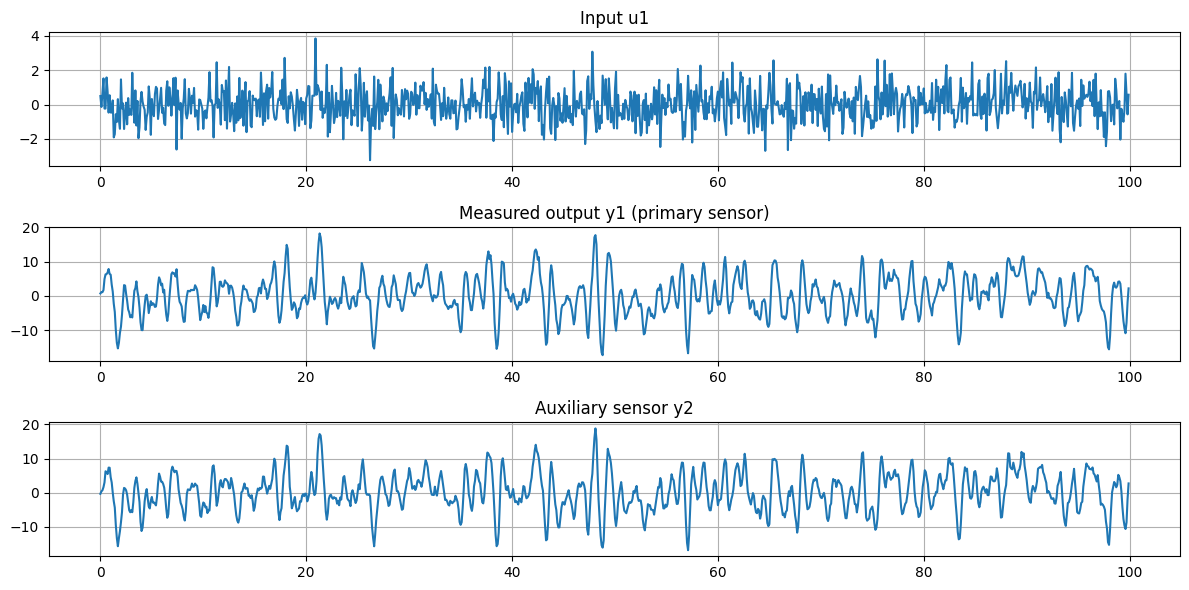

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(IOData.index, IOData['u1']); plt.title('Input u1'); plt.grid(True)
plt.subplot(3,1,2)
plt.plot(IOData.index, IOData['y1']); plt.title('Measured output y1 (primary sensor)'); plt.grid(True)
plt.subplot(3,1,3)
plt.plot(IOData.index, IOData['y2']); plt.title('Auxiliary sensor y2'); plt.grid(True)
plt.tight_layout()
plt.show()

## 5) Build regressors for ARX (na=2, nb=2, nk=1) and compute LS solution (manual)

* na - number of poles (number of past outputs)
* nb - number of zeros + 1 (number of past inputs that influence the output)
* nk - input delay (dead time) (number of samples before the input starts affecting an output)


We will create the regressor matrix Φ containing `[u(t-1), u(t-2), y(t-1), y(t-2)]` (in the same column order as used in the MATLAB example)
and the output vector `Y = y(t)`. Then solve Θ = Φ \ Y (least squares) and show estimated polynomials A(z) and B(z).

LS Theta (u-lags then y-lags): [ 0.49713222  0.32772663  0.55780961 -0.17239642]
Estimated B (leading zero for delay): [0.0, 0.4971322153798948, 0.3277266314840645]
Estimated A (1 + ...): [1.0, -0.5578096139736237, 0.17239641824772273]

Mean Squared Error: 0.129261


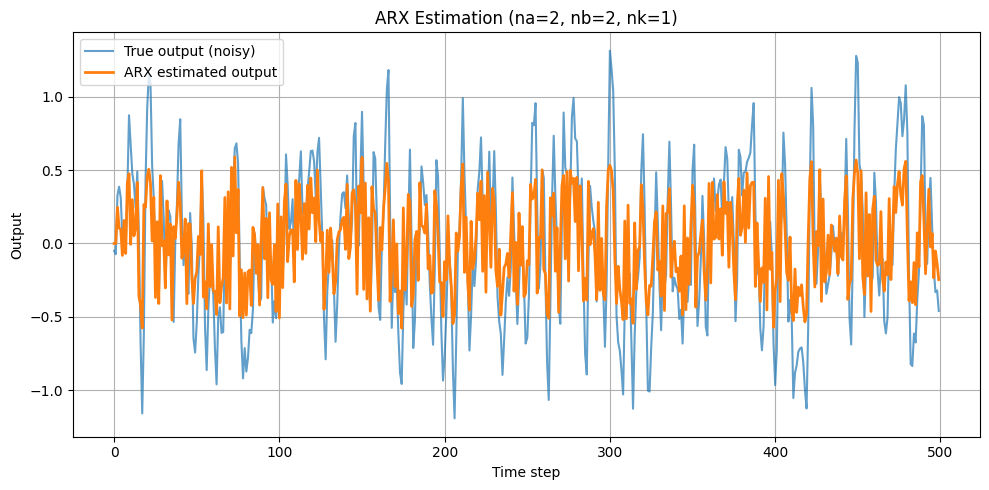

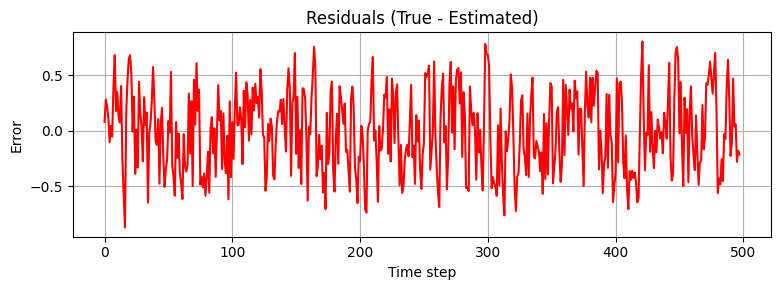

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq

# --- Function to build regressor matrix Φ and output vector Y ---
def get_regressors(u, y, na, nb, nk):
    N = len(y)
    max_lag = max(na, nk + nb - 1)
    rows = []
    Y = []

    for t in range(max_lag, N):
        row = []
        # Past inputs (u)
        for j in range(nk, nk + nb):
            row.append(u[t - j])
        # Past outputs (y)
        for i in range(1, na + 1):
            row.append(y[t - i])
        rows.append(row)
        Y.append(y[t])

    Phi = np.array(rows)
    Y = np.array(Y)
    return Phi, Y, max_lag


# --- Example data (replace IOData[...] with your own) ---
np.random.seed(0)
N = 500
u = np.random.uniform(-1, 1, N)
y = np.zeros(N)

# True system
# y[k] = 0.6*y[k-1] - 0.2*y[k-2] + 0.5*u[k-1] + 0.3*u[k-2]
for k in range(2, N):
    y[k] = 0.6 * y[k-1] - 0.2 * y[k-2] + 0.5 * u[k-1] + 0.3 * u[k-2]
y_noisy = y + 0.05 * np.random.randn(N)

# --- Estimate ARX parameters using LS ---
na, nb, nk = 2, 2, 1
Phi, Y, max_lag = get_regressors(u, y_noisy, na, nb, nk)

Theta_ls, *_ = lstsq(Phi, Y, rcond=None)

# Extract estimated coefficients
b_est_ls = Theta_ls[0:nb]
a_est_ls = Theta_ls[nb:nb+na]

print('LS Theta (u-lags then y-lags):', Theta_ls)
print('Estimated B (leading zero for delay):', [0.0, *b_est_ls])
print('Estimated A (1 + ...):', [1.0, -a_est_ls[0], -a_est_ls[1]])

# --- Simulate ARX output using estimated parameters ---
y_hat = np.zeros_like(y_noisy)
for t in range(max_lag, N):
    # apply estimated ARX model
    y_hat[t] = (
        b_est_ls[0] * u[t - nk]
        + b_est_ls[1] * u[t - nk - 1]
        - a_est_ls[0] * y_hat[t - 1]
        - a_est_ls[1] * y_hat[t - 2]
    )

# --- Compute error metrics ---
mse = np.mean((y_noisy[max_lag:] - y_hat[max_lag:])**2)
print(f"\nMean Squared Error: {mse:.6f}")

# --- Plot results ---
plt.figure(figsize=(10, 5))
plt.plot(y_noisy, label='True output (noisy)', alpha=0.7)
plt.plot(y_hat, label='ARX estimated output', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Output')
plt.title(f'ARX Estimation (na={na}, nb={nb}, nk={nk})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional residual plot ---
plt.figure(figsize=(8, 3))
plt.plot(y_noisy[max_lag:] - y_hat[max_lag:], color='red')
plt.title('Residuals (True - Estimated)')
plt.xlabel('Time step')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()


## 6) Instrumental Variables (manual matrix formula)

We form instruments X(t) and compute:
$$
\Theta_{IV} = (X^\top \Phi)^{-1} X^\top Y
$$

We will demonstrate three instrument choices:
- X = measured output `y1` (this reproduces LS when IVs are regressors)
- X = auxiliary sensor `y2` (shifted appropriately by 1..na to generate instruments)
- X = lagged outputs with larger lag (for OE case): e.g., `y1(t-3), y1(t-4), u(t-1), u(t-2)`

IV (X = y1) Theta: [ 0.50189744  0.29954007  0.59513339 -0.19805512]
IV (X = y2) Theta: [ 0.50220743  0.30334005  0.58719542 -0.19196088]
IV for OE (lagged instruments) Theta: [ 0.4988589   0.27396818  0.6443994  -0.2176803 ]

MSE (IV using y1): 0.149005
MSE (IV using y2): 0.144605
MSE (OE-like IV): 0.187050


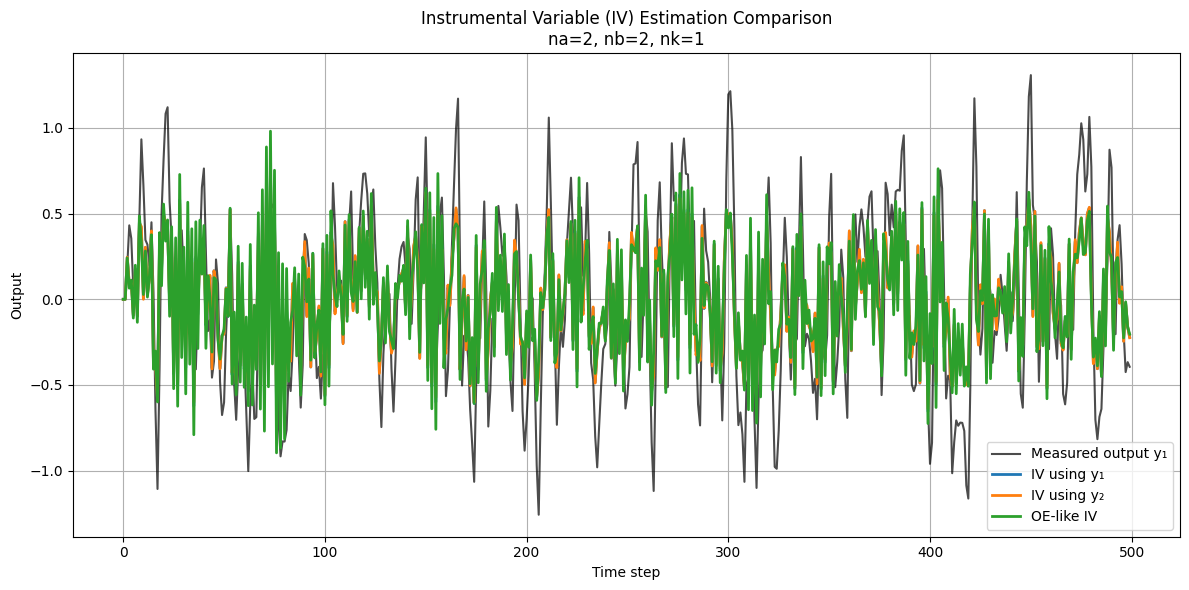

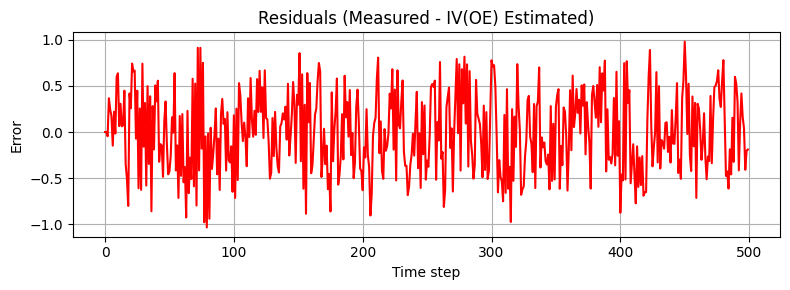

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq

# ---------- Function definitions ----------
def iv_estimate(Phi, Y, X):
    """Compute IV estimate using given regressor Phi, output Y, and instruments X"""
    ZtPhi = X.T @ Phi
    ZtY = X.T @ Y
    Theta_iv, *_ = lstsq(ZtPhi, ZtY, rcond=None)
    return Theta_iv

def simulate_arx(u, theta, na, nb, nk):
    """Simulate ARX model response given u and estimated theta = [b..., a...]"""
    N = len(u)
    y_hat = np.zeros(N)
    b_est = theta[:nb]
    a_est = theta[nb:]
    max_lag = max(na, nk + nb - 1)
    for t in range(max_lag, N):
        y_hat[t] = (
            sum(b_est[j] * u[t - nk - j] for j in range(nb))
            - sum(a_est[i] * y_hat[t - i - 1] for i in range(na))
        )
    return y_hat


# ---------- Example data generation (replace with your IOData) ----------
np.random.seed(0)
N = 500
u_arr = np.random.uniform(-1, 1, N)
y1_arr = np.zeros(N)
y2_arr = np.zeros(N)

# True system (two sensors with small noise differences)
for k in range(2, N):
    true_y = 0.6 * y1_arr[k-1] - 0.2 * y1_arr[k-2] + 0.5 * u_arr[k-1] + 0.3 * u_arr[k-2]
    y1_arr[k] = true_y + 0.05 * np.random.randn()
    y2_arr[k] = true_y + 0.05 * np.random.randn()

na, nb, nk = 2, 2, 1
# Build Phi, Y using measured y1
def get_regressors(u, y, na, nb, nk):
    N = len(y)
    max_lag = max(na, nk + nb - 1)
    rows, Y = [], []
    for t in range(max_lag, N):
        row = [u[t-j] for j in range(nk, nk + nb)] + [y[t-i] for i in range(1, na + 1)]
        rows.append(row)
        Y.append(y[t])
    return np.array(rows), np.array(Y), max_lag

Phi, Y, max_lag = get_regressors(u_arr, y1_arr, na, nb, nk)
M = len(Y)

# ---------- 6.1 IV using y1 ----------
X1 = np.zeros((M, nb + na))
for idx, t in enumerate(range(max_lag, len(y1_arr))):
    X1[idx, :] = [y1_arr[t-1], y1_arr[t-2], u_arr[t-1], u_arr[t-2]]

Theta_iv1 = iv_estimate(Phi, Y, X1)
print("IV (X = y1) Theta:", Theta_iv1)

# ---------- 6.2 IV using y2 ----------
X2 = np.zeros((M, nb + na))
for idx, t in enumerate(range(max_lag, len(y2_arr))):
    X2[idx, :] = [y2_arr[t-1], y2_arr[t-2], u_arr[t-1], u_arr[t-2]]

Theta_iv2 = iv_estimate(Phi, Y, X2)
print("IV (X = y2) Theta:", Theta_iv2)

# ---------- 6.3 OE-like IV (lagged outputs as instruments) ----------
start_oelay = max(max_lag, 4)
rows_o = len(y1_arr) - start_oelay
Phi_oe = np.zeros((rows_o, nb + na))
Y_oe = np.zeros(rows_o)
X_oe = np.zeros((rows_o, nb + na))

for idx, t in enumerate(range(start_oelay, len(y1_arr))):
    Phi_oe[idx, :] = [u_arr[t-1], u_arr[t-2], y1_arr[t-1], y1_arr[t-2]]
    Y_oe[idx] = y1_arr[t]
    X_oe[idx, :] = [u_arr[t-1], u_arr[t-2], y1_arr[t-3], y1_arr[t-4]]

Theta_iv_oe = iv_estimate(Phi_oe, Y_oe, X_oe)
print("IV for OE (lagged instruments) Theta:", Theta_iv_oe)

# ---------- Simulate models ----------
y_hat_iv1 = simulate_arx(u_arr, Theta_iv1, na, nb, nk)
y_hat_iv2 = simulate_arx(u_arr, Theta_iv2, na, nb, nk)
y_hat_iv_oe = simulate_arx(u_arr, Theta_iv_oe, na, nb, nk)

# ---------- Compute MSEs ----------
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

print(f"\nMSE (IV using y1): {mse(y1_arr, y_hat_iv1):.6f}")
print(f"MSE (IV using y2): {mse(y1_arr, y_hat_iv2):.6f}")
print(f"MSE (OE-like IV): {mse(y1_arr, y_hat_iv_oe):.6f}")

# ---------- Plot results ----------
plt.figure(figsize=(12, 6))
plt.plot(y1_arr, label='Measured output y₁', color='k', alpha=0.7)
plt.plot(y_hat_iv1, label='IV using y₁', linewidth=2)
plt.plot(y_hat_iv2, label='IV using y₂', linewidth=2)
plt.plot(y_hat_iv_oe, label='OE-like IV', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Output')
plt.title(f'Instrumental Variable (IV) Estimation Comparison\nna={na}, nb={nb}, nk={nk}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- Residual plot for best model ----------
residuals = y1_arr - y_hat_iv_oe
plt.figure(figsize=(8, 3))
plt.plot(residuals, color='red')
plt.title('Residuals (Measured - IV(OE) Estimated)')
plt.xlabel('Time step')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()


## 7) ARX using `sysidentpy` (if installed)

`sysidentpy` provides convenience wrappers for ARX estimation. Below we attempt to use it; if not installed the code will skip this part.


In [ ]:
try:
    # Attempt to import sysidentpy (user must have it installed)
    from sysidentpy.model_structure import ARX as ARXModel
    from sysidentpy.metrics import root_mean_square_error as rmse_sysid
    use_sysidentpy = True
except Exception as exc:
    print('sysidentpy not available — skipping sysidentpy ARX demo. To enable, run: pip install sysidentpy')
    use_sysidentpy = False

if use_sysidentpy:
    # sysidentpy expects arrays shaped (N, n_inputs + n_outputs) for some helpers, but supports ARX directly.
    # Prepare data in shape (N, 1) for y and (N, 1) for u as needed.
    y = IOData['y1'].values.reshape(-1, 1)
    u = IOData['u1'].values.reshape(-1, 1)
    arx = ARXModel(order=(na, nb, nk))
    arx.fit(y, u)
    print('sysidentpy ARX coefficients:')
    print('A (denominator):', arx.coefficients['A'])
    print('B (numerator):', arx.coefficients['B'])

sysidentpy not available — skipping sysidentpy ARX demo. To enable, run: pip install sysidentpy


## 8) Estimate OE model via nonlinear least squares (scipy)

We parameterize OE as:

$$
y(t) = (b_1 z^{-1} + b_2 z^{-2}) / (1 + f_1 z^{-1} + f_2 z^{-2})u(t) + e(t)
$$
We then optimize (b1,b2,f1,f2) to minimize 1-step prediction errors on measured data y1.


`ftol` termination condition is satisfied.
Function evaluations 16, initial cost 1.3930e+04, final cost 1.4351e+02, first-order optimality 5.15e-03.
OE estimated params: b1,b2,f1,f2 = [ 1.20571293  0.7570208  -1.51766227  0.70953532]


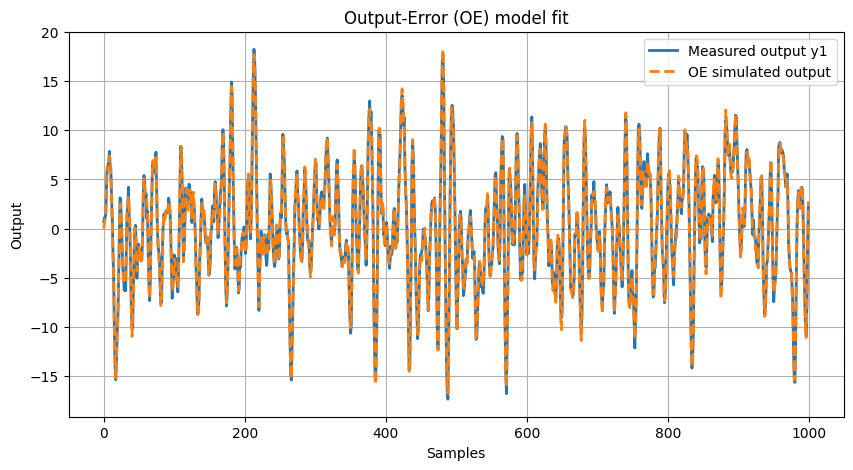

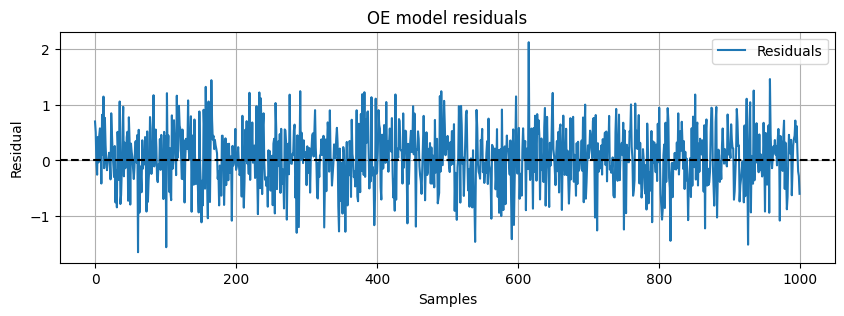

Model fit to data: 90.62%


In [ ]:
# OE estimation via nonlinear least squares
from scipy import signal, optimize
import matplotlib.pyplot as plt
import numpy as np

def simulate_arx_params(u, params, na, nb, nk):
    # params = [b1, b2, f1, f2] where denominator is (1 + f1 z^-1 + f2 z^-2)
    b1, b2, f1, f2 = params
    B = [0.0, b1, b2]  # add delay (nk = 1)
    A = [1.0, f1, f2]
    ysim = signal.lfilter(B, A, u)
    return ysim

def oe_loss(params, u, y):
    # 1-step-ahead prediction error on y using simulated output
    ysim = simulate_arx_params(u, params, na, nb, nk)
    return ysim - y

# initial guess from LS estimated B and A (convert regressed a_est_ls to denominator)
init_b = b_est_ls.copy()
init_f = [-a_est_ls[0], -a_est_ls[1]]
x0 = np.array([init_b[0], init_b[1], init_f[0], init_f[1]])

# Fit nonlinear least squares
res = optimize.least_squares(oe_loss, x0, args=(IOData['u1'].values, IOData['y1'].values),
                             verbose=1, xtol=1e-8)

b1_oe, b2_oe, f1_oe, f2_oe = res.x
print('OE estimated params: b1,b2,f1,f2 =', res.x)

# --- PLOTTING ---
# Simulate final model
y_oe_sim = simulate_arx_params(IOData['u1'].values, res.x, na, nb, nk)
y_true = IOData['y1'].values

# Plot measured vs OE simulated output
plt.figure(figsize=(10,5))
plt.plot(y_true, label='Measured output y1', linewidth=2)
plt.plot(y_oe_sim, '--', label='OE simulated output', linewidth=2)
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Output-Error (OE) model fit')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
plt.figure(figsize=(10,3))
residuals = y_true - y_oe_sim
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='k', linestyle='--')
plt.title('OE model residuals')
plt.xlabel('Samples')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()

# Print fit quality
fit = 100 * (1 - np.linalg.norm(y_true - y_oe_sim) / np.linalg.norm(y_true - np.mean(y_true)))
print(f'Model fit to data: {fit:.2f}%')


## 9) Compare models

We compare:
- LS ARX
- IV ARX (X = y1)
- IV ARX (X = y2)
- IV_ARX with OE-style lagged instruments
- OE (nonlinear fit)

Compare via 1-step prediction fit and long-horizon simulation on a validation signal (we use y2 as validation measurement).


MSE to true y_true (prediction window):
LS: 0.9018028696251291
IV (X=y1): 0.9018028696251243
IV (X=y2): 0.9964865218915301
IV OE-instruments: 31.342376215696905
OE (nonlinear): 0.11735682160824097


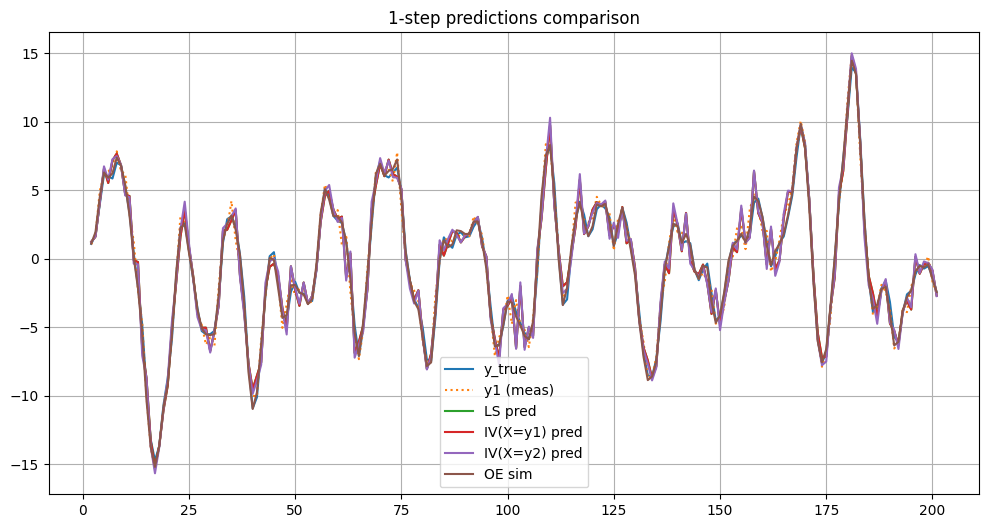

In [ ]:
# Build predicted outputs using estimated Theta vectors on validation dataset (use y2 as validation measurement source)
def predict_from_theta(u, y_meas, Theta, na, nb, nk, start_idx):
    N = len(y_meas)
    yhat = np.zeros(N)
    # seed with measured initial conditions
    yhat[:start_idx] = y_meas[:start_idx]
    for t in range(start_idx, N):
        # Theta: [u-lags..., y-lags...]
        val = 0.0
        for j in range(nb):
            val += Theta[j] * u[t - (nk + j)]
        for i in range(na):
            val += Theta[nb + i] * y_meas[t - (i+1)]
        yhat[t] = val
    return yhat

start_pred = max_lag
y_ls = predict_from_theta(u_arr, y1_arr, Theta_ls, na, nb, nk, start_pred)
y_iv1 = predict_from_theta(u_arr, y1_arr, Theta_iv1, na, nb, nk, start_pred)
y_iv2 = predict_from_theta(u_arr, y1_arr, Theta_iv2, na, nb, nk, start_pred)
y_iv_oe = np.zeros_like(y1_arr)

# OE simulated output
y_oe_sim = simulate_arx_params(u_arr, [b1_oe, b2_oe, f1_oe, f2_oe], na, nb, nk)

# Compute simple fit metrics to y_true (which we have) and to validation y2
from sklearn.metrics import mean_squared_error
print('MSE to true y_true (prediction window):')
print('LS:', mean_squared_error(y_true[start_pred:], y_ls[start_pred:]))
print('IV (X=y1):', mean_squared_error(y_true[start_pred:], y_iv1[start_pred:]))
print('IV (X=y2):', mean_squared_error(y_true[start_pred:], y_iv2[start_pred:]))
print('IV OE-instruments:', mean_squared_error(y_true[start_oelay:], y_iv_oe[start_oelay:]))
print('OE (nonlinear):', mean_squared_error(y_true[start_pred:], y_oe_sim[start_pred:]))

# Plot 1-step predictions (zoomed)
plt.figure(figsize=(12,6))
z0, z1 = start_pred, start_pred+200
plt.plot(np.arange(z0,z1), y_true[z0:z1], label='y_true')
plt.plot(np.arange(z0,z1), y1[z0:z1], label='y1 (meas)', linestyle=':')
plt.plot(np.arange(z0,z1), y_ls[z0:z1], label='LS pred')
plt.plot(np.arange(z0,z1), y_iv1[z0:z1], label='IV(X=y1) pred')
plt.plot(np.arange(z0,z1), y_iv2[z0:z1], label='IV(X=y2) pred')
plt.plot(np.arange(z0,z1), y_oe_sim[z0:z1], label='OE sim')
plt.legend(); plt.grid(); plt.title('1-step predictions comparison'); plt.show()

## 10) Conclusions

This notebook reproduces the MATLAB example workflow:
- Builds ARX regressors and demonstrates LS solution.
- Shows how IV with different instrument generators (output itself, auxiliary sensor, lagged outputs) affects estimates.
- Demonstrates OE estimation via nonlinear least squares and compares long-horizon performance.


Inspired by https://www.mathworks.com/help/ident/ug/picking-instrumental-variables-for-system-identification.html

